In [2]:
from imports import *

1.- Semana pasada

In [2]:
image = np.load("/data/vidales/images/image_realistic_4comp_v0402_con_inv_sin_modely_2.npy")

2. Corrección inversión

3. Corrección inversión y dos matrices para modelo en forma de Y

In [7]:
pe_image = np.load("/data/vidales/images/pe_image_realistic_4comp_v0402_sin_inv.npy")
time_image = np.load("/data/vidales/images/time_image_realistic_4comp_v0402.npy_sin_inv.npy")

In [8]:
table = pq.read_table('variables_v0402.parquet')
nuvT_c = ak.from_iter(table.column('nuvT_c').to_pylist())
#nuvT_c_bunch = ak.from_iter(table.column('nuvT_c_bunch').to_pylist())
dEpromx = ak.from_iter(table.column('dEpromx_4').to_pylist())
dEpromy = ak.from_iter(table.column('dEpromy_4').to_pylist())
dEpromz = ak.from_iter(table.column('dEpromz_4').to_pylist())
del table

In [9]:
dEpromx = np.array(dEpromx).flatten()
dEpromy = np.array(dEpromy).flatten()
dEpromz = np.array(dEpromz).flatten()
dEpromx = dEpromx.reshape(-1, 1)
dEpromy = dEpromy.reshape(-1, 1)
dEpromz = dEpromz.reshape(-1, 1)

In [5]:
print(np.shape(pe_image))
print(np.shape(dEpromy))

(21796, 59, 70, 8)
(21796, 1)


1.-

In [10]:
inverted_image = image[:, ::-1, :, :]

NameError: name 'image' is not defined

In [12]:
# prueba (los mapas originales están invertidos en y)
# Invert along the 59 dimension (axis 1)
inverted_pe_image = pe_image[:, ::-1, :, :]
inverted_time_image = time_image[:, ::-1, :, :]

In [6]:
assert np.shape(image)[0] == np.shape(dEpromx)[0]
assert np.shape(image)[0] == np.shape(dEpromy)[0]
assert np.shape(image)[0] == np.shape(dEpromz)[0]

In [16]:
#y = np.column_stack((nuvT_c, dEpromx_f, dEpromy_f, dEpromz_f))
y = np.column_stack((dEpromx, dEpromy, dEpromz))
y_np = ak.to_numpy(y)
print("Merged y_np:")
print(y_np)
print(np.shape(y_np))

Merged y_np:
[[-141.81035117  140.83112553   74.82157564]
 [-128.18496115  158.65734985  187.35995061]
 [  89.7728596  -156.06595153  218.71311199]
 ...
 [-124.34233789   15.40607009  319.10272126]
 [ 122.74146747   88.72589418  287.34965045]
 [  36.9916876    78.19434956  251.45103767]]
(21796, 3)


In [17]:
from sklearn.preprocessing import MinMaxScaler
# Define the column indices you want to scale to [0, 1] and [-1, 1]
# For 4 entries (t,x,y,z):

columns_0_to_1 = [2]  # For example, columns 0 and 2 to scale to [0, 1]
columns_minus1_to_1 = [0,1]  # For example, columns 1 and 3 to scale to [-1, 1]

# For 3 entries (x,y,z):

#columns_0_to_1 = [2]  # For example, columns 0 and 2 to scale to [0, 1]
#columns_minus1_to_1 = [0, 1]  # For example, columns 1 and 3 to scale to [-1, 1]

# Initialize two scalers
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
scaler_minus1_1 = MinMaxScaler(feature_range=(-1, 1))

# Apply scaling for columns that need [0, 1]
y_np_scaled_0_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_0_1[:, columns_0_to_1] = scaler_0_1.fit_transform(y_np[:, columns_0_to_1])

# Apply scaling for columns that need [-1, 1]
y_np_scaled_minus1_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_minus1_1[:, columns_minus1_to_1] = scaler_minus1_1.fit_transform(y_np[:, columns_minus1_to_1])

# Combine the results (scaled data)
y_scaled_combined = np.copy(y_np)  # Start with the original data
y_scaled_combined[:, columns_0_to_1] = y_np_scaled_0_1[:, columns_0_to_1]
y_scaled_combined[:, columns_minus1_to_1] = y_np_scaled_minus1_1[:, columns_minus1_to_1]

# Print the scaled data
print("Scaled Data (columns 1 and 4 -> scaled to [0, 1] and columns 2 and 3 -> scaled to [-1, 1]):")
print(y_scaled_combined)

Scaled Data (columns 1 and 4 -> scaled to [0, 1] and columns 2 and 3 -> scaled to [-1, 1]):
[[-0.70778976  0.69523988  0.13987098]
 [-0.63959104  0.7834291   0.36412399]
 [ 0.45134609 -0.77355807  0.42660082]
 ...
 [-0.62035768  0.0747418   0.62664522]
 [ 0.61636279  0.43746685  0.5633715 ]
 [ 0.18716222  0.3853656   0.49183704]]


In [18]:
test_size = int(np.floor(0.30*np.shape(y_np)[0]) )
print(test_size)

6538


In [9]:
x_train, x_test = inverted_image[:-test_size], inverted_image[-test_size:]
print('x_train dim.:',x_train.shape)
print('x_test dim.:', x_test.shape)

x_train dim.: (15258, 59, 70, 16)
x_test dim.: (6538, 59, 70, 16)


In [19]:
x_train_pe, x_test_pe = inverted_pe_image[:-test_size], inverted_pe_image[-test_size:]
print('x_train dim.:',x_train_pe.shape)
print('x_test dim.:', x_test_pe.shape)

x_train dim.: (15258, 59, 70, 8)
x_test dim.: (6538, 59, 70, 8)


In [20]:
x_train_time, x_test_time = inverted_time_image[:-test_size], inverted_time_image[-test_size:]
print('x_train dim.:',x_train_time.shape)
print('x_test dim.:', x_test_time.shape)

x_train dim.: (15258, 59, 70, 8)
x_test dim.: (6538, 59, 70, 8)


In [24]:
y_train, y_test = y_scaled_combined[:-test_size], y_scaled_combined[-test_size:]

**Previous model**

In [13]:
def alberto_cnn_model(x_train):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """

    input = layers.Input(shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]))

    model = layers.LayerNormalization()(input)

    model = layers.Conv2D(128, (3, 3), padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2, 2),padding='same')(model)
    model = layers.Dropout(0.25)(model)

    model = layers.Conv2D(256, (3, 3), padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    model = layers.Dropout(0.25)(model)

    model = layers.Conv2D(512, (3, 3), padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    model = layers.Dropout(0.4)(model)

    model = layers.Flatten()(model)

    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.1)(model)

    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dense(256, activation='relu')(model)

    output = layers.Dense(4, activation='linear')(model)

    # Create the model
    model_def = models.Model(inputs=input, outputs=output)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

**Current model**

**cambiar a mitad al usar solo XAS**

In [11]:
def create_cnn_model(x_train, conv_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.Conv2D(32, conv_dim, padding='same')(input_layer)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Fourth convolutional block
    model = layers.Conv2D(256, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    
    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model) 
    
    # Output layer
    output_layer = layers.Dense(3, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

**Current model 2- RESNET**

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

def resnet50_regression(x_train):
    """
    Build a modified ResNet-50 model for a custom input size with 16 channels.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input = layers.Input(shape=input_shape)

    # Modify the first convolution layer to accept 16 input channels
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Add the residual blocks with appropriate downsampling and kernel sizes
    def conv_block(input, filters, kernel_size=3, stride=1, downsample=False):
        shortcut = input
        x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(4 * filters, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        if downsample:
            shortcut = layers.Conv2D(4 * filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # Define stages with the adjusted downsampling
    x = conv_block(x, 64, downsample=True)
    for _ in range(2):
        x = conv_block(x, 64)

    x = conv_block(x, 128, stride=2, downsample=True)
    for _ in range(3):
        x = conv_block(x, 128)

    x = conv_block(x, 256, stride=1, downsample=True) # Typically it would be with stride 2 however our image size 57x60 not 256x256
    for _ in range(5):
        x = conv_block(x, 256)

    x = conv_block(x, 512, stride=1, downsample=True) # Typically it would be with stride 2 however our image size 57x60 not 256x256
    for _ in range(2):
        x = conv_block(x, 512)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.4)(x)  # Add Dropout before Dense layer

    # Output layer (for regression or classification)
    output = layers.Dense(4)(x)  # 4 output units for regression task (adjust as needed)

    model = models.Model(inputs=input, outputs=output)

    # Compile the model (example for regression task)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    return model

**Y-model**

In [21]:
def y_model(x_train_pe, x_train_time, conv_dim):
    from tensorflow.keras import layers, models
    from tensorflow.keras.optimizers import Adam
    
    """
    Creates a CNN model that takes two inputs (pe_image and time_image),
    processes them through separate convolutional blocks, and then merges them.
    
    Parameters:
    - x_train_pe: The input data for the photoelectron (pe) images.
    - x_train_time: The input data for the time images.
    - conv_dim: The kernel size for the convolution layers.
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layers for both images
    input_pe = layers.Input(shape=(x_train_pe.shape[1], x_train_pe.shape[2], x_train_pe.shape[3]))
    input_time = layers.Input(shape=(x_train_time.shape[1], x_train_time.shape[2], x_train_time.shape[3]))

    # First convolutional block for pe_image
    pe_model = layers.Conv2D(32, conv_dim, padding='same')(input_pe)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    # Second convolutional block for pe_image
    pe_model = layers.Conv2D(64, (3,3), padding='same')(pe_model)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    # Third convolutional block for pe_image
    pe_model = layers.Conv2D(128, (3,3), padding='same')(pe_model)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    # Fourth convolutional block for pe_image
    pe_model = layers.Conv2D(256, (3,3), padding='same')(pe_model)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    # First convolutional block for time_image
    time_model = layers.Conv2D(32, conv_dim, padding='same')(input_time)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    # Second convolutional block for time_image
    time_model = layers.Conv2D(64, (3,3), padding='same')(time_model)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    # Third convolutional block for time_image
    time_model = layers.Conv2D(128, (3,3), padding='same')(time_model)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    # Fourth convolutional block for time_image
    time_model = layers.Conv2D(256, (3,3), padding='same')(time_model)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    # Merge both models
    merged = layers.concatenate([pe_model, time_model])

    # Flatten the merged output and pass through dense layers
    merged = layers.Flatten()(merged)
    merged = layers.Dense(1024, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(512, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(256, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)

    # Output layer
    output_layer = layers.Dense(3, activation='linear')(merged)

    # Create the model
    model_def = models.Model(inputs=[input_pe, input_time], outputs=output_layer)

    # Compile the model
    model_def.compile(loss='mse', optimizer=Adam(), metrics=['mse'])

    return model_def

**Previous model**

In [13]:
previous_model = alberto_cnn_model(x_train)
previous_model.summary()

NameError: name 'alberto_cnn_model' is not defined

**Current model**

In [12]:
current_model= create_cnn_model(x_train, (5,5))

current_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 59, 70, 16)]      0         
                                                                 
 conv2d (Conv2D)             (None, 59, 70, 32)        12832     
                                                                 
 batch_normalization (BatchN  (None, 59, 70, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 59, 70, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 35, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 35, 64)        18496 

In [22]:
current_model= y_model(x_train_pe, x_train_time, (5,5))

current_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 59, 70, 8)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 59, 70, 8)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 59, 70, 32)   6432        ['input_1[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 59, 70, 32)   6432        ['input_2[0][0]']                
                                                                                              

In [13]:
y_pred, history= train_and_predict(current_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=16)

2025-02-04 23:24:53.807302: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4032994560 exceeds 10% of free system memory.
2025-02-04 23:24:56.886617: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4032994560 exceeds 10% of free system memory.


Epoch 1/100
954/954 [==============================] - ETA: 0s - loss: 0.3912 - mse: 0.3912

2025-02-04 23:25:10.017146: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1728124160 exceeds 10% of free system memory.
2025-02-04 23:25:11.333411: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1728124160 exceeds 10% of free system memory.


954/954 [==============================] - 15s 12ms/step - loss: 0.3912 - mse: 0.3912 - val_loss: 0.1291 - val_mse: 0.1291 - lr: 0.0010
Epoch 2/100
954/954 [==============================] - 8s 9ms/step - loss: 0.1199 - mse: 0.1199 - val_loss: 0.0753 - val_mse: 0.0753 - lr: 0.0010
Epoch 3/100
954/954 [==============================] - 8s 9ms/step - loss: 0.0897 - mse: 0.0897 - val_loss: 0.0623 - val_mse: 0.0623 - lr: 0.0010
Epoch 4/100
954/954 [==============================] - 8s 9ms/step - loss: 0.0793 - mse: 0.0793 - val_loss: 0.0574 - val_mse: 0.0574 - lr: 0.0010
Epoch 5/100
954/954 [==============================] - 8s 9ms/step - loss: 0.0720 - mse: 0.0720 - val_loss: 0.0562 - val_mse: 0.0562 - lr: 0.0010
Epoch 6/100
954/954 [==============================] - 8s 9ms/step - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0465 - val_mse: 0.0465 - lr: 0.0010
Epoch 7/100
954/954 [==============================] - 9s 10ms/step - loss: 0.0638 - mse: 0.0638 - val_loss: 0.0495 - val_mse: 0.0495 

2025-02-04 23:35:49.367112: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1728124160 exceeds 10% of free system memory.


In [25]:
y_pred, history= train_and_predict(current_model, (x_train_pe, x_train_time), y_train, (x_test_pe, x_test_time), y_test, epochs=100, batch_size=16)

2025-02-04 23:56:49.120221: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2016497280 exceeds 10% of free system memory.
2025-02-04 23:56:51.587903: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2016497280 exceeds 10% of free system memory.
2025-02-04 23:56:53.134387: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2016497280 exceeds 10% of free system memory.
2025-02-04 23:56:54.236494: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2016497280 exceeds 10% of free system memory.


Epoch 1/100
954/954 [==============================] - 20s 17ms/step - loss: 0.6113 - mse: 0.6113 - val_loss: 0.0696 - val_mse: 0.0696 - lr: 0.0010
Epoch 2/100
954/954 [==============================] - 12s 13ms/step - loss: 0.0755 - mse: 0.0755 - val_loss: 0.0460 - val_mse: 0.0460 - lr: 0.0010
Epoch 3/100
954/954 [==============================] - 12s 13ms/step - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0459 - val_mse: 0.0459 - lr: 0.0010
Epoch 4/100
954/954 [==============================] - 12s 13ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0298 - val_mse: 0.0298 - lr: 0.0010
Epoch 5/100
954/954 [==============================] - 12s 12ms/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0311 - val_mse: 0.0311 - lr: 0.0010
Epoch 6/100
954/954 [==============================] - 12s 12ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0373 - val_mse: 0.0373 - lr: 0.0010
Epoch 7/100
954/954 [==============================] - 12s 13ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.

In [15]:
#current_model.save('saved_archives/ophit_cnn_model_v2101_c_1.h5')

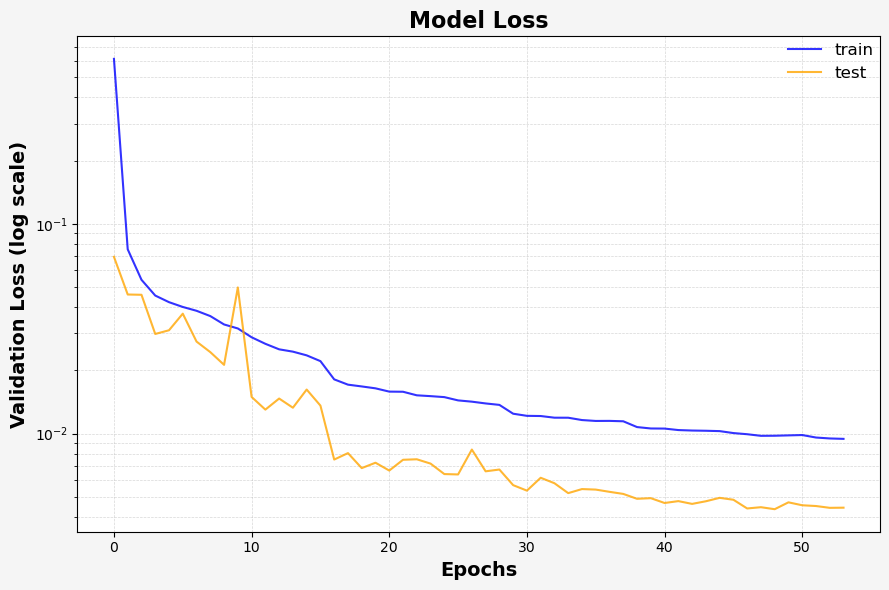

In [26]:
import matplotlib.pyplot as plt

# Access each model's history
model_history = history.history

# Plotting the validation loss for all models
plt.figure(figsize=(9, 6))

# Plot each model's validation loss with smooth lines, subtle markers, and refined styling
plt.plot(model_history['loss'], label='train', color='blue', linestyle='-', markersize=8, alpha=0.8)
plt.plot(model_history['val_loss'], label='test', color='orange', linestyle='-', markersize=8, alpha=0.8)

# Enhance plot appearance
plt.yscale('log')  # Use logarithmic scale on y-axis
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Loss', fontsize=16, fontweight='bold')
#plt.ylim(0.01,0.1)
# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()


In [27]:
# Initialize a copy of the scaled combined data
y_pred_inverse= np.copy(y_pred)
y_test_inverse= np.copy(y_test)

# Inverse scaling for columns scaled to [0, 1]
y_pred_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_pred[:, columns_0_to_1])
y_test_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_test[:, columns_0_to_1])

# Inverse scaling for columns scaled to [-1, 1]
y_pred_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_pred[:, columns_minus1_to_1])
y_test_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_test[:, columns_minus1_to_1])

In [ ]:
fig, axs = plt.subplots(2,4,figsize=(16,9))

axs[0,0].scatter(y_test_inverse[:,0], y_pred_inverse[:,0], color="black",s=5)
axs[0,0].grid()

axs[0,0].plot([0,20],[0,20],color="r")
axs[0,0].title.set_text('nuvT')
axs[0,0].set_xlim([0,20])
axs[0,0].set_ylim([0,20])
axs[0,0].set_ylabel('Predicted [ns]')
axs[0,0].set_xlabel('Real [ns]')

im0 = axs[1,0].hist2d(y_test_inverse[:,0], y_pred_inverse[:,0].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im0[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([0,20],[0,20],'r')
axs[1,0].set_xlim([0,20])
axs[1,0].set_ylim([0,20])
axs[1,0].set_ylabel('Predicted [ns]')
axs[1,0].set_xlabel('Real [ns]')
axs[1,0].set_facecolor('#440154')


axs[0,1].scatter(y_test_inverse[:,1], y_pred_inverse[:,1], color="black",s=5)
axs[0,1].grid()

axs[0,1].plot([-200,200],[-200,200],color="r")
axs[0,1].title.set_text('Coordinate X')
axs[0,1].set_xlim([-200,200])
axs[0,1].set_ylim([-200,200])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')


im1 = axs[1,1].hist2d(y_test_inverse[:,1], y_pred_inverse[:,1].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1,1])
axs[1,1].grid()

axs[1,1].plot([-200,200],[-200,200],'r')
axs[1,1].set_xlim([-200,200])
axs[1,1].set_ylim([-200,200])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')


axs[0,2].scatter(y_test_inverse[:,2], y_pred_inverse[:,2], color="black",s=5)
axs[0,2].grid()

axs[0,2].plot([-200,200],[-200,200],color="r")
axs[0,2].title.set_text('Coordinate Y')
axs[0,2].set_xlim([-200,200])
axs[0,2].set_ylim([-200,200])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im2 = axs[1,2].hist2d(y_test_inverse[:,2], y_pred_inverse[:,2].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im2[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].plot([-200,200],[-200,200],'r')
axs[1,2].set_xlim([-200,200])
axs[1,2].set_ylim([-200,200])
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')


axs[0,3].scatter(y_test_inverse[:,3], y_pred_inverse[:,3], color="black",s=5)
axs[0,3].grid()

axs[0,3].plot([0,500],[0,500],color="r")
axs[0,3].title.set_text('Coordinate Z')
axs[0,3].set_xlim([0,500])
axs[0,3].set_ylim([0,500])
axs[0,3].set_ylabel('Predicted [cm]')
axs[0,3].set_xlabel('Real [cm]')


im3 = axs[1,3].hist2d(y_test_inverse[:,3], y_pred_inverse[:,3].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im3[3], ax=axs[1,3])
axs[1,3].grid()

axs[1,3].set_xlim([0,500])
axs[1,3].set_ylim([0,500])
axs[1,3].plot([0,500],[0,500], 'r')
axs[1,3].set_ylabel('Predicted [cm]')
axs[1,3].set_xlabel('Real [cm]')
axs[1,3].set_facecolor('#440154')

fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

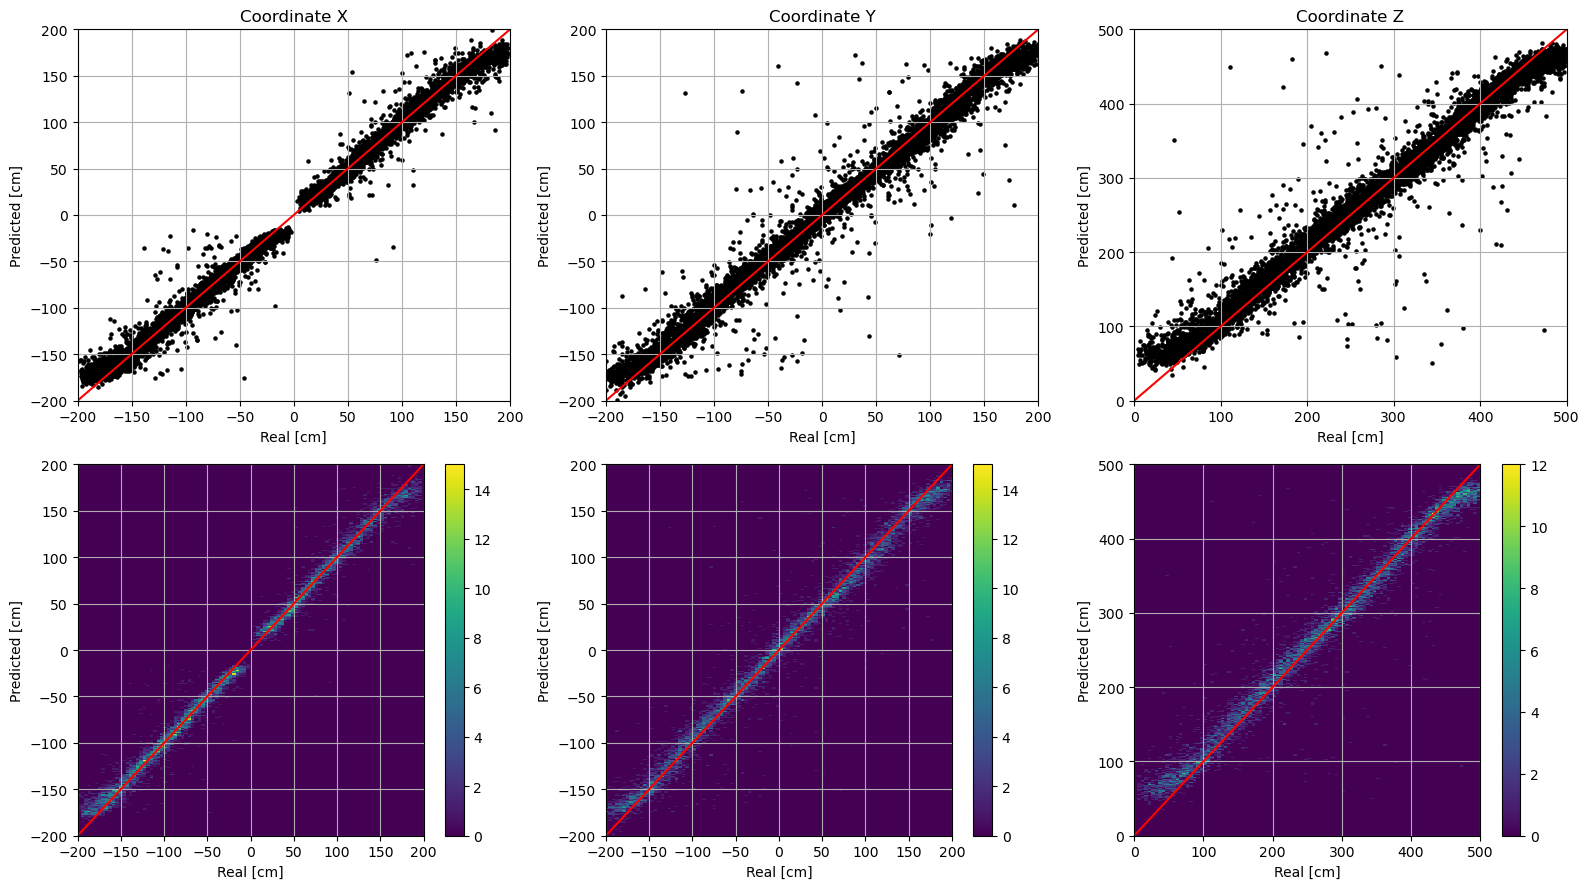

In [28]:
fig, axs = plt.subplots(2,3,figsize=(16,9))



axs[0,0].scatter(y_test_inverse[:,0], y_pred_inverse[:,0], color="black",s=5)
axs[0,0].grid()

axs[0,0].plot([-200,200],[-200,200],color="r")
axs[0,0].title.set_text('Coordinate X')
axs[0,0].set_xlim([-200,200])
axs[0,0].set_ylim([-200,200])
axs[0,0].set_ylabel('Predicted [cm]')
axs[0,0].set_xlabel('Real [cm]')


im1 = axs[1,0].hist2d(y_test_inverse[:,0], y_pred_inverse[:,0].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([-200,200],[-200,200],'r')
axs[1,0].set_xlim([-200,200])
axs[1,0].set_ylim([-200,200])
axs[1,0].set_ylabel('Predicted [cm]')
axs[1,0].set_xlabel('Real [cm]')
axs[1,0].set_facecolor('#440154')


axs[0,1].scatter(y_test_inverse[:,1], y_pred_inverse[:,1], color="black",s=5)
axs[0,1].grid()

axs[0,1].plot([-200,200],[-200,200],color="r")
axs[0,1].title.set_text('Coordinate Y')
axs[0,1].set_xlim([-200,200])
axs[0,1].set_ylim([-200,200])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')


im2 = axs[1,1].hist2d(y_test_inverse[:,1], y_pred_inverse[:,1].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im2[3], ax=axs[1,1])
axs[1,1].grid()

axs[1,1].plot([-200,200],[-200,200],'r')
axs[1,1].set_xlim([-200,200])
axs[1,1].set_ylim([-200,200])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')


axs[0,2].scatter(y_test_inverse[:,2], y_pred_inverse[:,2], color="black",s=5)
axs[0,2].grid()

axs[0,2].plot([0,500],[0,500],color="r")
axs[0,2].title.set_text('Coordinate Z')
axs[0,2].set_xlim([0,500])
axs[0,2].set_ylim([0,500])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im3 = axs[1,2].hist2d(y_test_inverse[:,2], y_pred_inverse[:,2].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im3[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].set_xlim([0,500])
axs[1,2].set_ylim([0,500])
axs[1,2].plot([0,500],[0,500], 'r')
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')

fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = y_pred_inverse[:, 0].flatten() - y_test_inverse[:, 0]
diffX = y_pred_inverse[:, 1].flatten() - y_test_inverse[:, 1]
diffY = y_pred_inverse[:, 2].flatten() - y_test_inverse[:, 2]
diffZ = y_pred_inverse[:, 3].flatten() - y_test_inverse[:, 3]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 4, figsize=(14, 4))

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin, hist_range):
    counts, bins, patches = axs[index].hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0)
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Call the function with updated range for nuvT
popt_nuvT = fit_and_plot_hist(diffnuvT, axs, 0, 'nuvT', 40, 175, hist_range=[-400, 400])
popt_X = fit_and_plot_hist(diffX, axs, 1, 'X', 65, 130, hist_range=[-250, 250])
popt_Y = fit_and_plot_hist(diffY, axs, 2, 'Y', 65, 130, hist_range=[-250, 250])
popt_Z = fit_and_plot_hist(diffZ, axs, 3, 'Z', 65, 135, hist_range=[-250, 250])


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


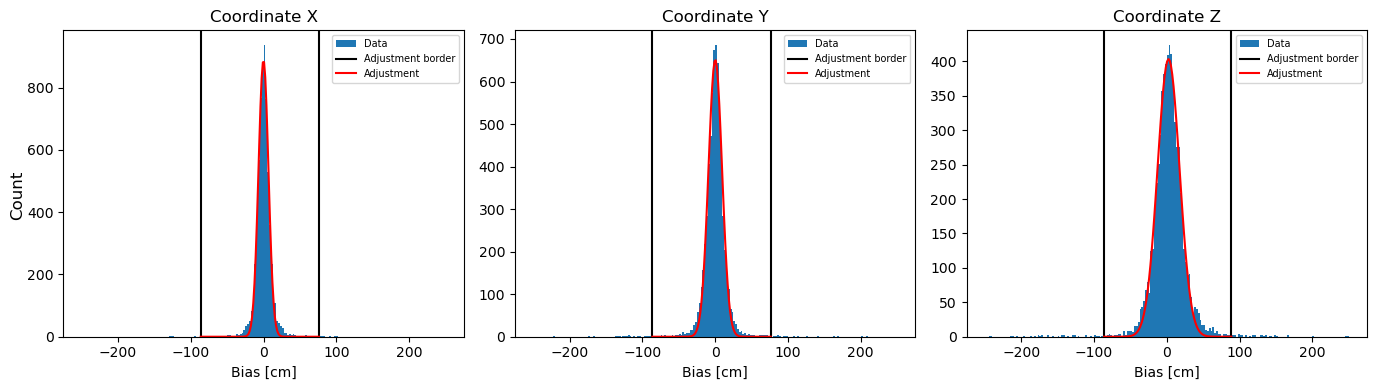

Bias Adjustment variables
------------------
Mean X = -0.04
Sigma X = 6.82
------------------
Mean Y = 0.14
Sigma Y = 9.32
------------------
Mean Z = 2.34
Sigma Z = 15.12
------------------


In [29]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value

diffX = y_pred_inverse[:, 0].flatten() - y_test_inverse[:, 0]
diffY = y_pred_inverse[:, 1].flatten() - y_test_inverse[:, 1]
diffZ = y_pred_inverse[:, 2].flatten() - y_test_inverse[:, 2]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin, hist_range):
    counts, bins, patches = axs[index].hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0)
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Call the function with updated range for nuvT

popt_X = fit_and_plot_hist(diffX, axs, 0, 'X', 65, 130, hist_range=[-250, 250])
popt_Y = fit_and_plot_hist(diffY, axs, 1, 'Y', 65, 130, hist_range=[-250, 250])
popt_Z = fit_and_plot_hist(diffZ, axs, 2, 'Z', 65, 135, hist_range=[-250, 250])


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


In [23]:
r2_x = r2_score(y_test_inverse[:, 0], y_pred_inverse[:, 0])     # Coordinate X
r2_y = r2_score(y_test_inverse[:, 1], y_pred_inverse[:, 1])     # Coordinate Y
r2_z = r2_score(y_test_inverse[:, 2], y_pred_inverse[:, 2])     # Coordinate Z

print(f"R2 (X): {r2_x:.4f}")
print(f"R2 (Y): {r2_y:.4f}")
print(f"R2 (Z): {r2_z:.4f}")

R2 (X): 0.9271
R2 (Y): 0.9001
R2 (Z): 0.9030


In [20]:
print('Gauss X')
print(np.std(diffX))
print(np.mean(diffX))

print('Gauss Y')
print(np.std(diffY))
print(np.mean(diffY))

print('Gauss Z')
print(np.std(diffZ))
print(np.mean(diffZ))

Gauss X
27.393241757766475
-0.6142951600290327
Gauss Y
27.236566239665013
-0.5034220949984536
Gauss Z
39.414459044481234
1.1878635292522397


### Visualize intermediate layers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def visualize_intermediate_layers(model, x_train, sample_index=0):
    """
    Visualizes intermediate layer outputs for a specific sample from the training data.
    
    Parameters:
    - model: The trained Keras model.
    - x_train: The training data.
    - sample_index: Index of the sample from x_train to visualize.
    """
    # Get the outputs of all intermediate layers
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = Model(inputs=model.input, outputs=successive_outputs)
    
    # Select a sample image from x_train
    sample_image = x_train[sample_index:sample_index + 1]  # Shape should be (1, height, width, channels)
    
    # Pass the image through the model to get intermediate representations
    successive_feature_maps = visualization_model.predict(sample_image)
    
    # Get layer names for labeling
    layer_names = [layer.name for layer in model.layers[1:]]
    
    # Plot each layer's feature map
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        if len(feature_map.shape) == 4:  # Only consider convolutional layers (ignore dense layers)
            n_features = feature_map.shape[-1]  # Number of filters
            size = feature_map.shape[1]  # Spatial dimensions
            
            # Create a grid for visualizing each filter's feature map
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                
                # Normalize the feature map values for better visualization
                x -= x.mean()
                x /= (x.std() + 1e-5)
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                
                # Resize or pad `x` if it doesn't match the expected dimensions
                if x.shape[1] < size:
                    x = np.pad(x, ((0, 0), (0, size - x.shape[1])), mode='constant')
                elif x.shape[1] > size:
                    x = x[:, :size]
                
                # Put each filter's activation in the display grid
                display_grid[:, i * size : (i + 1) * size] = x
            
            # Display the grid
            scale = 20. / n_features
            plt.figure(figsize=(scale * n_features, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()

# Use the function to visualize intermediate representations of your model
# Assuming x_train is your training data and create_cnn_model has been defined
#model, _ = create_cnn_model(x_train, conv_dim=(3, 3), maxpool_dim=(2, 2))
#visualize_intermediate_layers(model, x_train)


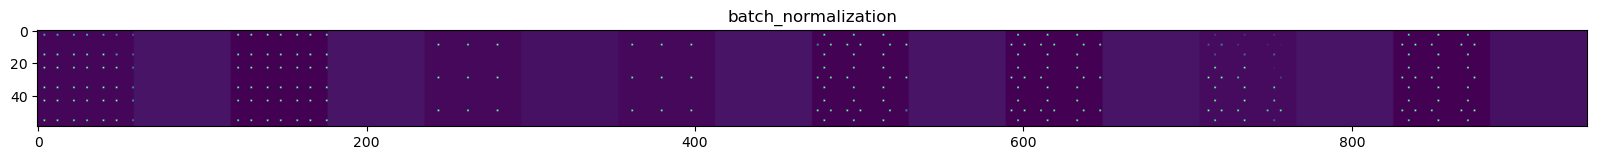

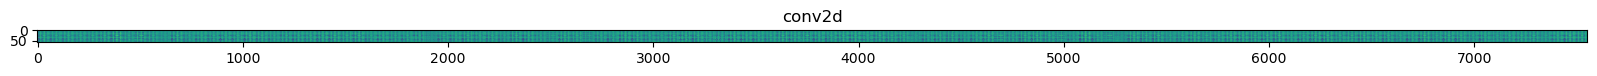

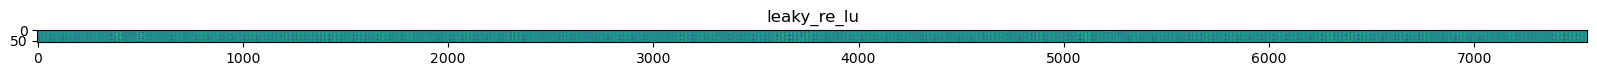

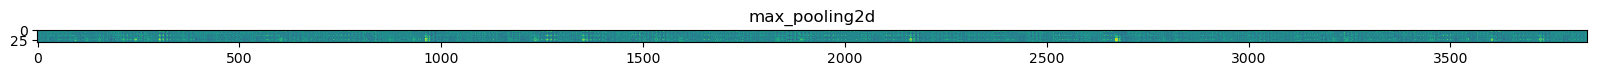

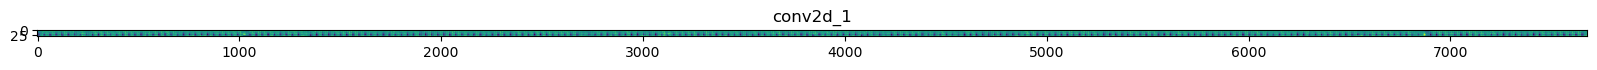

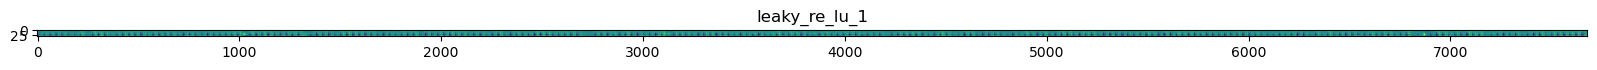

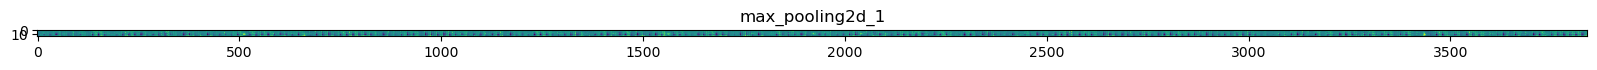

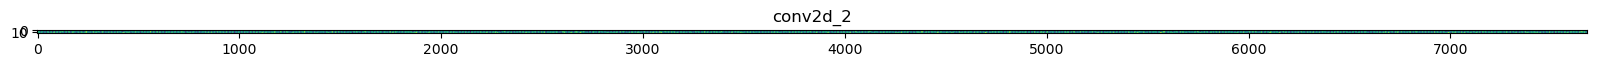

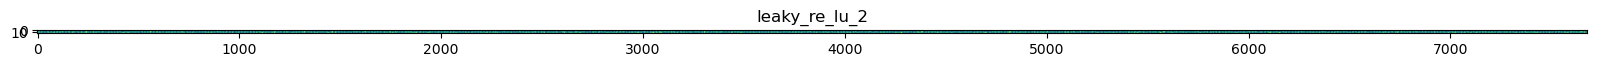

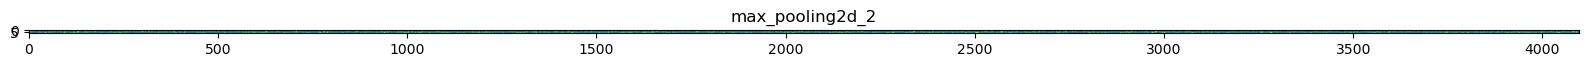

In [ ]:
visualize_intermediate_layers(model_4compreal, x_train)

### Visualize areas of interest

In [3]:
try:
    current_model = tf.keras.models.load_model('saved_archives/ophit_cnn_model_v2101_c_1.h5')
    print("Modelo cargado exitosamente.")
except Exception as e:
    print("Error al cargar el modelo:", e)

Modelo cargado exitosamente.


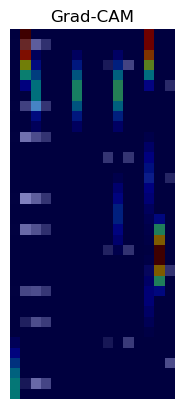

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import cv2

def generate_gradcam(model, image, layer_name='conv2d', class_idx=None):
    # Crea un modelo que extrae las activaciones de la capa convolucional seleccionada
    grad_model = Model(inputs=model.input,
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # Asegúrate de que los valores de la imagen sean flotantes y habilita el cálculo de gradientes
        image_input = tf.convert_to_tensor(image, dtype=tf.float32)
        tape.watch(image_input)
        
        # Calcula las activaciones de la capa y la salida de la red
        conv_outputs, predictions = grad_model(image_input)
        
        if class_idx is None:
            # Si no se especifica un índice de clase, se usa el índice de la clase con mayor probabilidad
            class_idx = np.argmax(predictions.numpy())
        
        # Calcula los gradientes de la clase seleccionada con respecto a las activaciones de la capa
        grads = tape.gradient(predictions[:, class_idx], conv_outputs)
        
    # Promedia los gradientes a través de la dimensión de los canales
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplica las activaciones por los gradientes ponderados
    cam = np.dot(conv_outputs[0], pooled_grads.numpy())

    # Escala el mapa para que tenga valores entre 0 y 1
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)

    return cam

def display_gradcam(image, cam, title="Grad-CAM"):
    # Redimensiona el mapa de activación para que coincida con las dimensiones de la imagen
    cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))
    
    # Muestra la imagen original con el mapa de activación superpuesto
    plt.imshow(image, cmap='gray')
    plt.imshow(cam_resized, cmap='jet', alpha=0.5)  # Mapa de calor en la imagen
    plt.title(title)
    plt.axis('off')
    plt.show()


# Asegúrate de que `image` tiene shape (1, 9, 36, 16)
# Si tu imagen original tiene más dimensiones, primero debes ajustar su forma.
# Si tienes varias imágenes, asegúrate de seleccionar una sola para gradcam:

# Aquí suponemos que la imagen tiene la forma correcta (1, 9, 36, 16)
image_input = image[3] 
image_input2 = image_input[None]  # Si 'image' tiene forma (9, 36, 16), agregamos la dimensión del batch

# Supongamos que `current_model` es tu modelo entrenado
gradcam = generate_gradcam(current_model, image_input2)  # El input debe tener shape (1, 9, 36, 16)
display_gradcam(image_input[0], gradcam)  # Ahora se pasa la imagen original de tamaño (9, 36, 16)


In [23]:
import matplotlib.pyplot as plt

def plot_gradcam(cam, title="Grad-CAM Heatmap"):
    # Display the Grad-CAM heatmap
    plt.imshow(cam, cmap='jet')  # Use 'jet' colormap for the heatmap
    plt.colorbar()  # Add color bar to show the heatmap intensity
    plt.title(title)  # Title of the plot
    plt.axis('off')  # Turn off axis labels
    plt.show()

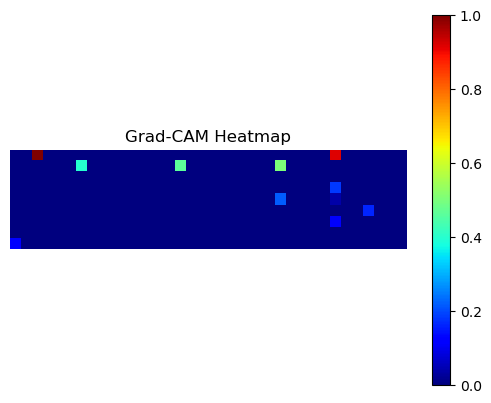

In [25]:
plot_gradcam(gradcam)

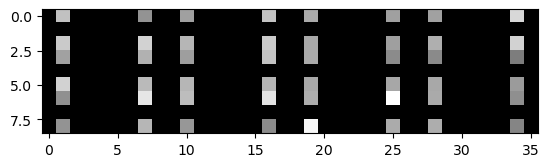

In [29]:
plt.imshow(image[3,:,:,2],cmap='gray')